In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pylab as plt

from functools import partial
import random

import theano.tensor as tt
from theano.tensor import slinalg
from theano import shared
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture, find_MAP
from pymc3 import DensityDist, CategoricalGibbsMetropolis
from pymc3.distributions import *
from pymc3 import gp
from pymc3 import advi, adam, fit, sample_ppc
from pymc3 import forestplot, traceplot
from pymc3.gp.util import plot_gp_dist

from sklearn.metrics import silhouette_score, calinski_harabaz_score

DATA_DIR = '../data/clean/'

## Import and extract data

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'subset_2yrs.csv', index_col=0)
                      .dropna(axis=1, thresh=7)).T # ONLY THOSE WITH 7 OBS
bmi_by_patient.head()

MRN,472613,584276,599209,689752,728998,730028,764134,794941,798124,832014,...,40891764,40897217,95586095,95977484,96193156,96495338,96505185,96796297,96798749,96892369
0,34.613679,34.142193,26.349156,18.796160,31.566288,22.725041,20.755906,20.302289,24.218798,25.295317,...,24.084359,36.596352,25.616987,41.179470,33.470148,41.052958,34.853982,24.807863,24.482496,35.874095
1,NaN,NaN,NaN,NaN,NaN,NaN,21.026407,20.302289,24.205390,23.714130,...,22.838821,36.600652,NaN,40.964368,34.011028,41.374758,NaN,26.608833,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,22.908206,20.901024,22.807572,NaN,...,21.288818,38.004260,NaN,NaN,NaN,41.746840,NaN,NaN,25.540993,NaN
3,NaN,NaN,NaN,18.853099,NaN,23.402535,NaN,NaN,24.117025,NaN,...,21.359046,39.853156,NaN,NaN,NaN,NaN,NaN,27.426742,NaN,NaN
4,NaN,NaN,NaN,19.633149,NaN,NaN,NaN,NaN,NaN,23.170579,...,22.441817,39.853156,NaN,NaN,32.062296,NaN,NaN,NaN,NaN,36.733106


In [3]:
bmi_by_patient.shape

(24, 100546)

Take all patients with more than 4 data points

In [4]:
# data_subset = bmi_resampled.copy()
# data_subset = bmi_by_patient.iloc[:, :200]
data_subset = bmi_by_patient.loc[:, bmi_by_patient.count() > 4]

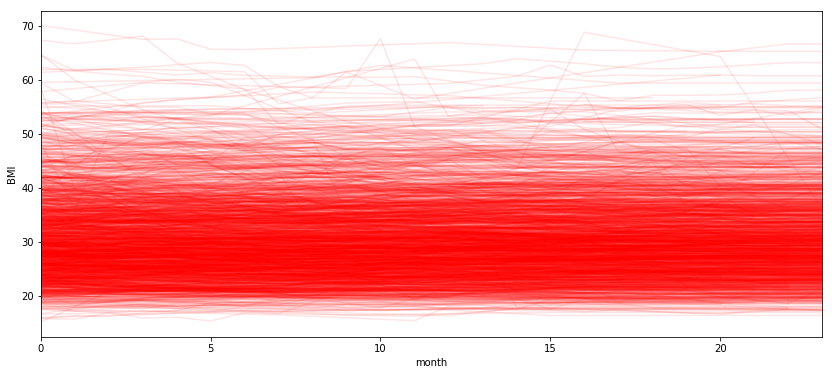

In [4]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.interpolate(limit=10)
            .plot(legend=False, alpha=0.1, ax=axes, color='r'))
axes.set_ylabel('BMI')
axes.set_xlabel('month');

## Estimate continuous time series using Gaussian processes

In [5]:
D, N = data_subset.shape
D, N

(24, 100546)

In [6]:
X = np.arange(D).reshape(-1, 1)

In [7]:
data_subset.head()

MRN,472613,584276,599209,689752,728998,730028,764134,794941,798124,832014,...,40891764,40897217,95586095,95977484,96193156,96495338,96505185,96796297,96798749,96892369
0,34.613679,34.142193,26.349156,18.796160,31.566288,22.725041,20.755906,20.302289,24.218798,25.295317,...,24.084359,36.596352,25.616987,41.179470,33.470148,41.052958,34.853982,24.807863,24.482496,35.874095
1,NaN,NaN,NaN,NaN,NaN,NaN,21.026407,20.302289,24.205390,23.714130,...,22.838821,36.600652,NaN,40.964368,34.011028,41.374758,NaN,26.608833,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,22.908206,20.901024,22.807572,NaN,...,21.288818,38.004260,NaN,NaN,NaN,41.746840,NaN,NaN,25.540993,NaN
3,NaN,NaN,NaN,18.853099,NaN,23.402535,NaN,NaN,24.117025,NaN,...,21.359046,39.853156,NaN,NaN,NaN,NaN,NaN,27.426742,NaN,NaN
4,NaN,NaN,NaN,19.633149,NaN,NaN,NaN,NaN,NaN,23.170579,...,22.441817,39.853156,NaN,NaN,32.062296,NaN,NaN,NaN,NaN,36.733106


In [8]:
data_centered = data_subset - data_subset.iloc[0]

In [13]:
data_centered.notnull().sum().max()

24

In [14]:
y = data_centered.T.values[:1000]
N = 1000

In [ ]:
with Model() as model:
    
    μ_l = Normal('μ_l', 0, sd=10)
    σ_l = HalfCauchy('σ_l', 3)
    
    ℓ = Normal("ℓ", mu=μ_l, sd=σ_l, shape=N)
    η = Normal("η", mu=0, sd=10, shape=N)
    
#     σ = Exponential("σ", 1)
    
    observed = [~np.isnan(yi) for yi in y]
    y_obs = [yi[oi] for yi,oi in zip(y,observed)]
    x = [np.argwhere(oi).reshape(-1, 1) for oi in observed]
    
    funcs = [(gp.mean.Constant(c=np.nanmean(y)), 
              tt.exp(η[i])**2 * gp.cov.Matern52(1, tt.exp(ℓ[i]))) for i in range(N)]
    
    gp_latent = [gp.Marginal(mean_func=m, cov_func=c) for m,c in funcs]
    
    obs = [gp.marginal_likelihood("obs_%i" % i, X=x[i], y=y_obs[i], noise=0) for i,gp in enumerate(gp_latent)]
    
#     f = [g.prior("f_%i" % i, X=x[i]) for i,g in enumerate(gp_latent)]
    
#     obs = [Normal("obs_%i" % i, mu=fi, sd=σ, observed=y_obs[i], shape=len(y_obs[i])) for i,fi in enumerate(f)]
    

In [20]:
with Model() as model:
    
    μ_l = Normal('μ_l', 0, sd=10)
    σ_l = HalfCauchy('σ_l', 3)
    
    ℓ = Normal("ℓ", mu=μ_l, sd=σ_l, shape=N)
    η = Normal("η", mu=0, sd=10, shape=N)
        
    observed = [~np.isnan(yi) for yi in y]
    y_obs = [yi[oi] for yi,oi in zip(y,observed)]
    x = [np.argwhere(oi).reshape(-1, 1) for oi in observed]
    
    funcs = [(gp.mean.Constant(c=np.nanmean(y)), 
              tt.exp(η[i])**2 * gp.cov.Matern52(1, tt.exp(ℓ[i]))) for i in range(N)]
    
    gp_latent = [gp.Latent(mean_func=m, cov_func=c) for m,c in funcs]    
    
    ν = Gamma("ν", alpha=2, beta=0.1)
    σ = HalfCauchy("σ", beta=5)
    obs = [StudentT("obs_%i" % i, mu=gp.prior("f_%i" % i, X=x[i]), 
                              lam=1.0/σ, 
                              nu=ν, 
                              observed=y_obs[i]) for i,gp in enumerate(gp_latent)]

INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


AssertionError: 

In [ ]:
with model:
    map_est = find_MAP()

In [11]:
with model:
    f_pred = [g.conditional("f_pred_%i" % i, Xnew=X) for i,g in enumerate(gp_latent)]
    pred_samples = sample_ppc([map_est], vars=f_pred, samples=100)

100%|██████████| 100/100 [05:07<00:00,  1.22s/it] 


In [12]:
def plot_traj(i, ax=None):
    sample = pred_samples['f_pred_%i' %i]
    if ax is None:
        fig, ax = plt.subplots()
    plot_gp_dist(ax, sample, X);
    obs_ind = ~np.isnan(y[i])
    ax.plot(X.flatten()[obs_ind], y[i,obs_ind], 'ko')

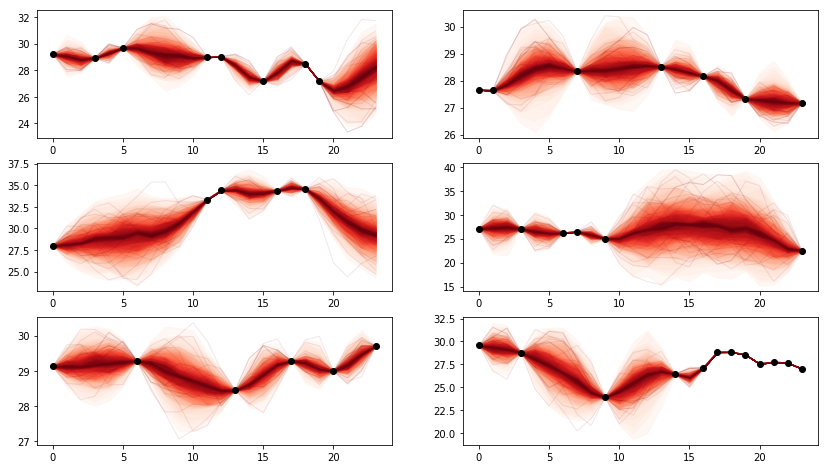

In [180]:
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

for ax in axes.ravel():
    plot_traj(np.random.randint(0, N), ax=ax)

In [14]:
mean_traj = np.array([pred_samples['f_pred_%i' %i].mean(0) for i in range(N)])

In [15]:
mean_traj_centered = np.array([traj - traj[0] for traj in mean_traj])

## Create clusters using K-means with soft-DTW distances

We will use a k-means clustering algorithm, based on dynamic time warping (DTW) as a distance metric. Unlike the Euclidean distance, DTW is able to compare asynchronous time series of varying size and is robust to elastic transformations in time. To be robust to such invariances, DTW computes a minimal cost alignment between time series using dynamic programming.

Soft-DTW is a formulation of DTW that computes the soft-minimum of all alignment costs, resulting in a differentiable loss function.

In [16]:
from tslearn.clustering import TimeSeriesKMeans

In [90]:
n_clusters = 32

In [93]:
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True)
y_pred_sdtw = sdtw_km.fit_predict(mean_traj_centered)


58.287 --> 20.934 --> 19.774 --> 19.213 --> 19.141 --> 19.078 --> 19.049 --> 18.940 --> 18.840 --> 18.882 --> 18.882 --> 


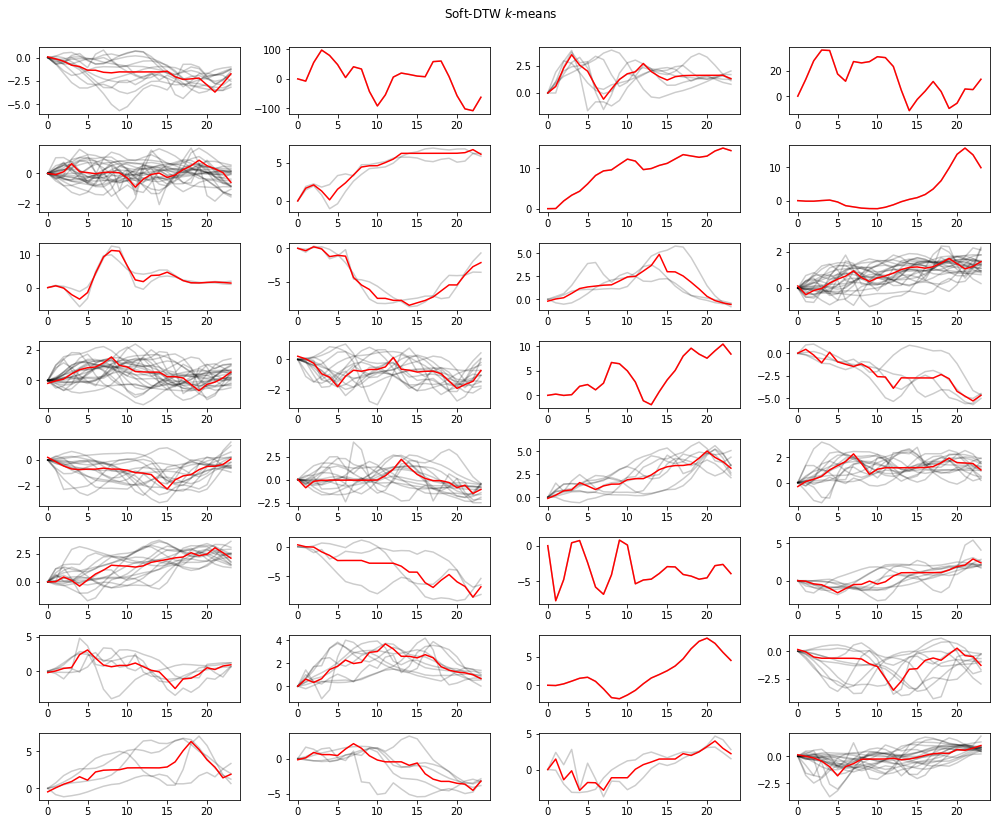

In [92]:
fig, axes = plt.subplots(8, 4, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_pred_sdtw == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

However, the initial placement of the cluster centers is random, so re-running the algorithm will produce slightly different results (though qualitatively similar).

In [185]:
n_clusters = 8

In [189]:
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True)
y_pred_sdtw = sdtw_km.fit_predict(mean_traj_centered)

345.231 --> 107.720 --> 102.060 --> 100.538 --> 102.094 --> 99.846 --> 98.961 --> 97.832 --> 99.634 --> 99.542 --> 94.496 --> 91.741 --> 89.783 --> 89.731 --> 89.271 --> 89.126 --> 89.287 --> 89.287 --> 


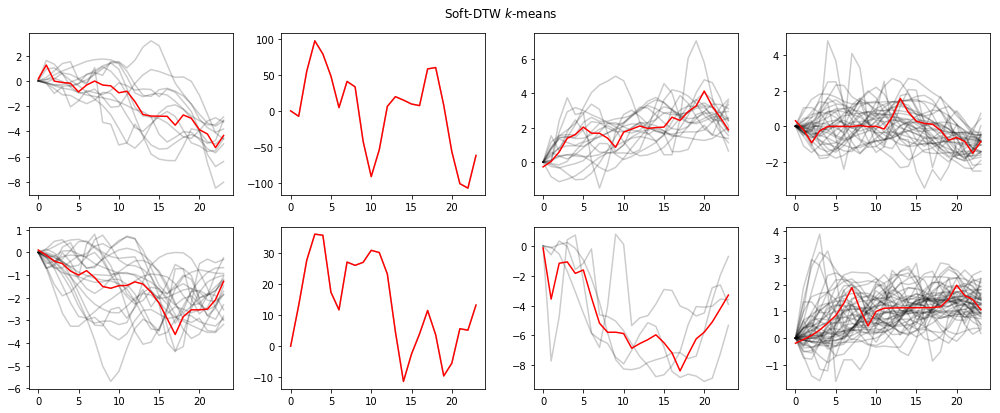

In [190]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_pred_sdtw == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

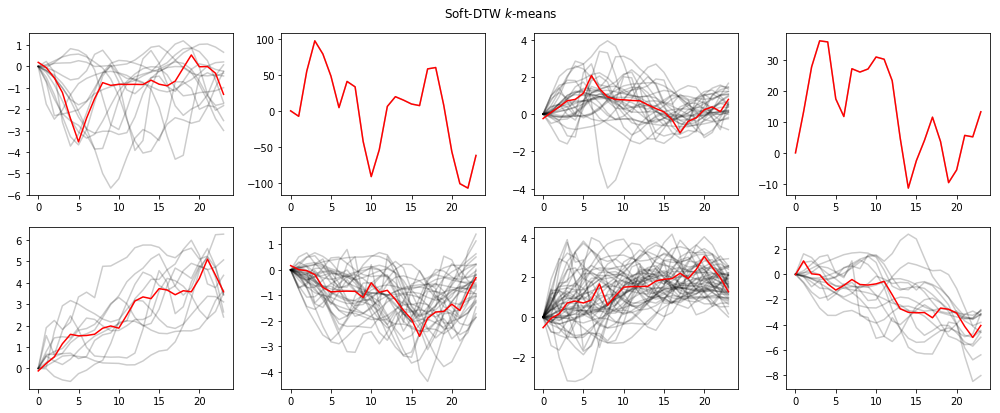

In [188]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_pred_sdtw == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In order to make inferences robust to this stochasticity, we run the alogorithm 1000 times, to quantify which individuals tend to cluster together

In [102]:
predictions = []
for i in range(1000):
    predictions.append(TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", 
                                        verbose=False,
                                        metric_params={"gamma_sdtw": .01}).fit_predict(mean_traj_centered))

In [107]:
comparisons = []
for i in range(N):
    counts = np.zeros(N)
    for row in predictions:
        current_cluster = row[i]
        counts += row==current_cluster
    comparisons.append(counts)
comparisons = np.array(comparisons)

Here is the correlation matrix among individuals. Brighter pixels are individuals that tend to end up in the same clusters based on 1000 clusterings.

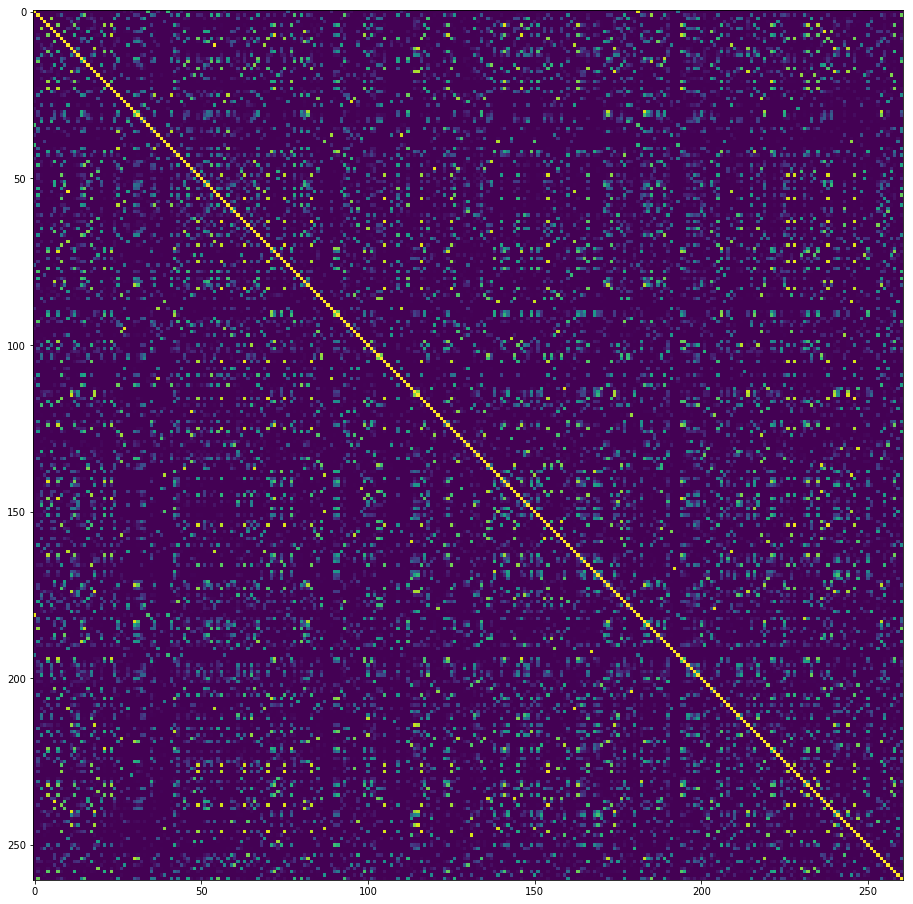

In [177]:
plt.figure(figsize=(16, 16))
plt.imshow(comparisons/1000)

In [113]:
(comparisons > 700).sum(1)

array([ 2,  6,  2,  1, 16,  2,  7, 15, 15,  7,  5,  8, 10,  1,  6,  7,  5,
       14,  8,  5,  1, 11,  1, 14,  1,  5,  8,  3,  1,  1,  7,  7,  1,  1,
        2,  2,  4,  3,  2,  5,  1,  5,  9,  2,  1,  4,  4,  6,  3, 18,  1,
        1,  2,  7,  5,  3, 18,  3,  6,  3,  3,  1,  1, 18,  3,  4,  7,  4,
        1,  5, 17,  6, 14,  3,  4, 16,  1,  9,  4,  1,  5,  6,  7, 18,  1,
        6,  5,  5,  1,  3,  5,  7,  1,  4,  1,  3,  7,  3,  3, 11,  5,  3,
        1,  8,  3, 18,  1,  1,  1,  2,  3,  1,  6,  4,  8,  8, 16,  6,  3,
        1,  5,  3,  1,  3, 12, 16,  2,  9,  3,  1,  3,  5,  2,  2,  4,  6,
        9,  6,  3,  5,  1, 15,  1,  2,  9,  5, 15,  3,  2,  3,  5,  3,  2,
        7, 17,  6,  2,  7,  7,  5,  2,  1,  5, 15,  1,  2, 10,  2,  3,  2,
        6,  1,  8, 13,  8,  3,  7,  3,  1,  3,  1,  3,  2,  7,  1,  6,  1,
        3,  4,  5,  1,  2,  2,  1, 15,  8,  1,  1,  1,  3,  1,  2,  5,  6,
        3,  4,  6,  1,  1,  5,  1,  3,  5,  1,  8,  1,  7,  4,  9,  8,  6,
       11,  1,  1,  1,  3

In [117]:
correlations = comparisons/1000

## Use DBSCAN to cluster based on the correlation matrix

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. 

In [127]:
from sklearn.cluster import DBSCAN
from tslearn.metrics import dtw

In [158]:
db_scanner = DBSCAN(eps=1, min_samples=1)
dbscan_pred = db_scanner.fit_predict((1-correlations))

In [168]:
dbscan_clusters = [i for i in range(dbscan_pred.max()) if (dbscan_pred==i).sum()>1]

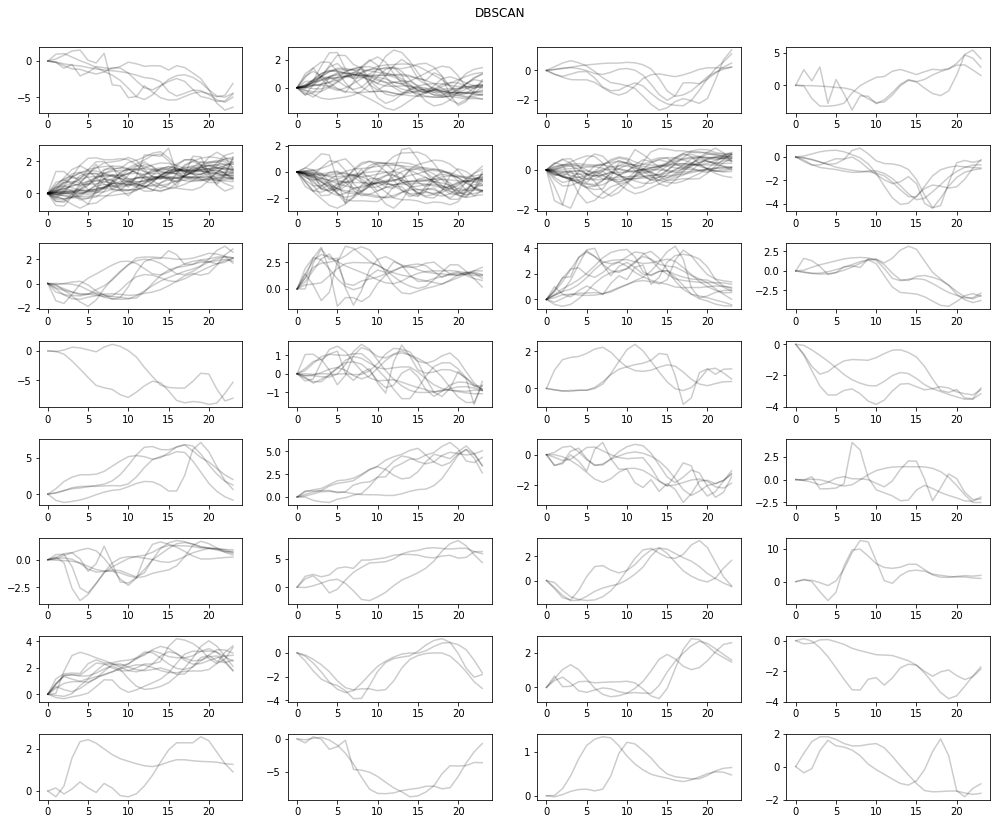

In [175]:
fig, axes = plt.subplots(8, 4, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[dbscan_pred == dbscan_clusters[i]]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
#     ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("DBSCAN")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Alternative clustering algorithms

K-means is not the only clustering approach we can use. For example, there are kernel-based methods.

In [23]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak

In [57]:
kernel_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters, 
                                        sigma=sigma_gak(mean_traj_centered), 
                                        n_init=20, 
                                        verbose=True)

y_kernel_pred = kernel_km.fit_predict(mean_traj_centered)


Init 1
384.568 --> 353.764 --> 348.295 --> 346.484 --> 343.610 --> 341.569 --> 340.391 --> 340.103 --> 339.579 --> 339.293 --> 338.903 --> 338.712 --> 338.560 --> 338.560 --> 
Init 2
384.332 --> 345.423 --> 340.332 --> 339.939 --> 339.238 --> 338.754 --> 338.576 --> 338.536 --> 338.536 --> 
Init 3
386.773 --> 355.949 --> 345.556 --> 344.413 --> 344.104 --> 343.683 --> 343.683 --> 
Init 4
384.937 --> 342.278 --> 340.811 --> 339.901 --> 338.960 --> 338.795 --> 338.731 --> 338.731 --> 
Init 5
385.275 --> 346.893 --> 345.268 --> 344.686 --> 344.365 --> 344.071 --> 343.638 --> 343.638 --> 
Init 6
383.247 --> 347.410 --> 340.532 --> 338.855 --> 338.625 --> 338.471 --> 338.471 --> 
Init 7
383.164 --> 352.445 --> 348.255 --> 346.949 --> 346.373 --> 345.408 --> 344.420 --> 343.732 --> 343.459 --> 343.208 --> 342.077 --> 340.313 --> 338.738 --> 338.408 --> 338.408 --> 
Init 8
387.065 --> 367.839 --> 361.253 --> 363.468 --> 364.514 --> 364.864 --> 365.163 --> 366.053 --> 365.580 --> 365.127 --> 3

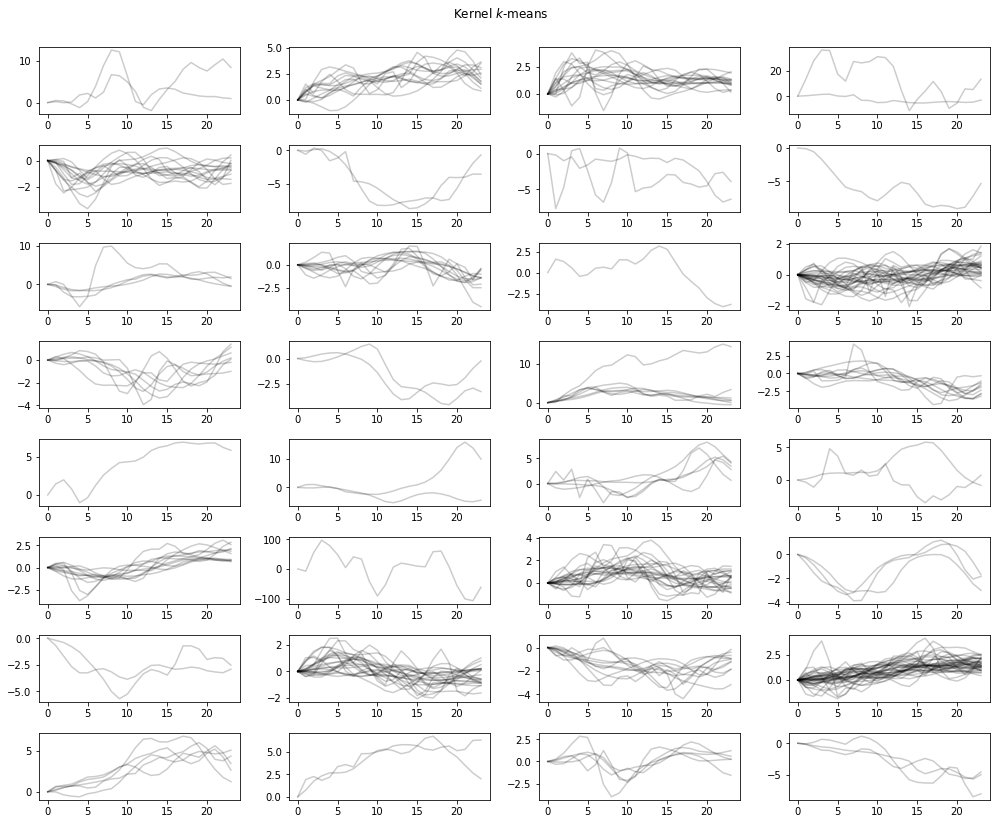

In [29]:
fig, axes = plt.subplots(8, 4, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_kernel_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
#     ax.plot(kernel_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Kernel $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])